In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import evaluate
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import time
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# --- 1. 配置 ---
BASELINE_FP32_MODEL_PATH = "./my_bert_sst2_finetuned/checkpoint-1800"
PRUNED_FP32_MODEL_PATH = "./models/bert_pruned_8_layers_finetuned/best_model"
PRUNED_FP16_MODEL_SAVE_PATH = "./models/bert_pruned_fp16_gpu"

# --- 修改点 1: 我们将使用这个统一的名称来加载分词器 ---
TOKENIZER_NAME = "bert-base-uncased" 
TEST_SENTENCE = "This movie is not bad at all, in fact it is surprisingly good!"
LATENCY_RUNS = 100
EVAL_BATCH_SIZE = 32

if not torch.cuda.is_available():
    raise RuntimeError("This experiment requires a GPU!")
DEVICE = torch.device("cuda")
print("Configuration set. Using GPU for conversion and evaluation.")
os.makedirs(PRUNED_FP16_MODEL_SAVE_PATH, exist_ok=True)

Configuration set. Using GPU for conversion and evaluation.


In [3]:
# =======================================================
# 步骤 2: 将剪枝后的FP32模型转换为FP16并保存
# =======================================================
print(f"Loading FP32 model from '{PRUNED_FP32_MODEL_PATH}' and converting to FP16...")
model_fp16 = AutoModelForSequenceClassification.from_pretrained(
    PRUNED_FP32_MODEL_PATH,
    torch_dtype=torch.float16
).to(DEVICE)
print("Model successfully converted to FP16 and moved to GPU.")

print(f"Saving FP16 model to '{PRUNED_FP16_MODEL_SAVE_PATH}'...")
model_fp16.save_pretrained(PRUNED_FP16_MODEL_SAVE_PATH)

# --- 修改点 2: 加载一次分词器并用它来保存，确保一致性 ---
tokenizer_to_save = AutoTokenizer.from_pretrained(PRUNED_FP32_MODEL_PATH)
tokenizer_to_save.save_pretrained(PRUNED_FP16_MODEL_SAVE_PATH)
print("FP16 model and tokenizer saved successfully.")

del model_fp16, tokenizer_to_save
torch.cuda.empty_cache()

Loading FP32 model from './models/bert_pruned_8_layers_finetuned/best_model' and converting to FP16...
Model successfully converted to FP16 and moved to GPU.
Saving FP16 model to './models/bert_pruned_fp16_gpu'...
FP16 model and tokenizer saved successfully.


In [4]:
# =======================================================
# 步骤 3: 辅助函数定义 (无变化)
# =======================================================
def get_model_size(path):
    # ... (函数内容保持不变) ...
    total_size = 0
    for dirpath, _, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size / (1024 * 1024)

def measure_latency(model, tokenizer, device, runs=100):
    # ... (函数内容保持不变) ...
    inputs = tokenizer(TEST_SENTENCE, return_tensors="pt").to(device)
    timings = []
    with torch.no_grad():
        for _ in range(20): _ = model(**inputs)
        for _ in range(runs):
            torch.cuda.synchronize()
            start_time = time.perf_counter()
            _ = model(**inputs)
            torch.cuda.synchronize()
            end_time = time.perf_counter()
            timings.append(end_time - start_time)
    return np.mean(timings) * 1000

def evaluate_accuracy(model, tokenizer, device, eval_dataloader):
    # ... (函数内容保持不变) ...
    metric = evaluate.load("accuracy")
    model.eval()
    for batch in tqdm(eval_dataloader, desc=f"Evaluating Accuracy"):
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'label']}
        with torch.no_grad():
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        predictions = torch.argmax(outputs.logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["label"])
    return metric.compute()["accuracy"]

In [5]:
# =======================================================
# 步骤 4: 准备评估数据集
# =======================================================
print("Preparing dataset for evaluation...")
# --- 修改点 3: 在这里统一加载分词器，供所有后续步骤使用 ---
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

raw_datasets = load_dataset("glue", "sst2")
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=128)
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets.set_format('torch')
eval_dataset = tokenized_datasets["validation"]
eval_dataloader = DataLoader(eval_dataset, batch_size=EVAL_BATCH_SIZE)
print("Dataset ready.")

Preparing dataset for evaluation...
Dataset ready.


In [6]:
# =======================================================
# 步骤 5: 评估三个模型的 尺寸、显存、延迟和精度
# =======================================================
results = []
models_to_compare = [
    {"name": "1. FP32 Baseline (12L)", "path": BASELINE_FP32_MODEL_PATH, "dtype": torch.float32},
    {"name": "5. Pruned FP32 (8L)", "path": PRUNED_FP32_MODEL_PATH, "dtype": torch.float32},
    {"name": "6. Pruned FP16 (8L, GPU-Only)", "path": PRUNED_FP16_MODEL_SAVE_PATH, "dtype": torch.float16}
]

for config in models_to_compare:
    print(f"\n{'='*20} EVALUATING: {config['name']} {'='*20}")
    current_results = {"Model": config['name']}
    current_results["Size (MB)"] = get_model_size(config['path'])
    
    # 加载模型
    model = AutoModelForSequenceClassification.from_pretrained(config['path'], torch_dtype=config['dtype']).to(DEVICE)
    # --- 修改点 4: 移除此处的 tokenizer 加载，使用前面已加载的全局 tokenizer ---
    # tokenizer = AutoTokenizer.from_pretrained(config['path']) # <--- 已删除
    
    # 测量峰值显存
    torch.cuda.reset_peak_memory_stats(DEVICE)
    inputs_for_mem = tokenizer(TEST_SENTENCE, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        _ = model(**inputs_for_mem)
    peak_mem_mb = torch.cuda.max_memory_allocated(DEVICE) / (1024 * 1024)
    current_results["Peak GPU Mem (MB)"] = peak_mem_mb
    
    # 测量延迟和精度 (传入全局 tokenizer)
    current_results["Latency (GPU, ms)"] = measure_latency(model, tokenizer, DEVICE)
    current_results["Accuracy (GPU)"] = evaluate_accuracy(model, tokenizer, DEVICE, eval_dataloader)
    
    results.append(current_results)
    del model
    torch.cuda.empty_cache()

# 展示对比结果
print(f"\n{'='*25} FINAL RESULTS {'='*25}")
df = pd.DataFrame(results)
for col in ["Size (MB)", "Peak GPU Mem (MB)", "Latency (GPU, ms)"]:
    df[col] = df[col].map('{:.2f}'.format)
df["Accuracy (GPU)"] = df["Accuracy (GPU)"].map('{:.4f}'.format)
print(df.to_markdown(index=False))


==================== EVALUATING: 1. FP32 Baseline (12L) ====================


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]


==================== EVALUATING: 5. Pruned FP32 (8L) ====================


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]


==================== EVALUATING: 6. Pruned FP16 (8L, GPU-Only) ====================


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]


========================= FINAL RESULTS =========================
| Model                         |   Size (MB) |   Peak GPU Mem (MB) |   Latency (GPU, ms) |   Accuracy (GPU) |
|:------------------------------|------------:|--------------------:|--------------------:|-----------------:|
| 1. FP32 Baseline (12L)        |     1253.16 |              428.26 |                3.23 |           0.93   |
| 5. Pruned FP32 (8L)           |      310.42 |              320.98 |                2.25 |           0.9278 |
| 6. Pruned FP16 (8L, GPU-Only) |      155.66 |              169.25 |                2.26 |           0.9266 |


In [7]:
# ==============================================================================
# 步骤 6: 批量延迟测试与可视化
# ==============================================================================
print(f"\n{'='*25} BATCH LATENCY VS THROUGHPUT TEST {'='*25}")
BATCH_SIZES = [1, 2, 4, 8, 16, 32, 64]
WARMUP_RUNS = 20
LATENCY_RUNS_BATCH = 100
try:
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['svg.fonttype'] = 'none' 
except Exception as e:
    print(f"注意：未能设置中文字体。错误信息: {e}")
    
# --- 修改点 2: 定义包含绘图信息在内的模型配置 ---
models_for_latency_test = [
    {
        "name": "1. FP32 Baseline (12L)",
        "path": BASELINE_FP32_MODEL_PATH,
        "dtype": torch.float32,
        "color": '#0173B2',
        "marker": 'x'
    },
    {
        "name": "5. Pruned FP32 (8L)",
        "path": PRUNED_FP32_MODEL_PATH,
        "dtype": torch.float32,
        "color": '#CC78BC',
        "marker": 'o'
    },
    {
        "name": "6. Pruned FP16 (8L, GPU-Only)",
        "path": PRUNED_FP16_MODEL_SAVE_PATH,
        "dtype": torch.float16,
        "color": '#D55E00',
        "marker": 's'
    }
]
latency_results = []
test_sentences = [TEST_SENTENCE] * max(BATCH_SIZES)

for model_config in models_for_latency_test:
    print(f"\n--- Testing Model: {model_config['name']} ---")
    model = AutoModelForSequenceClassification.from_pretrained(
        model_config['path'], 
        torch_dtype=model_config['dtype']
    ).to(DEVICE).eval()
    # --- 修改点 5: 再次移除此处的 tokenizer 加载 ---
    # tokenizer = AutoTokenizer.from_pretrained(model_config['path']) # <--- 已删除

    for bs in BATCH_SIZES:
        # 使用全局 tokenizer
        inputs = tokenizer(test_sentences[:bs], return_tensors="pt", padding=True).to(DEVICE)
        
        timings = []
        with torch.no_grad():
            for _ in range(WARMUP_RUNS): _ = model(**inputs)
            for _ in range(LATENCY_RUNS_BATCH):
                torch.cuda.synchronize()
                start = time.perf_counter()
                _ = model(**inputs)
                torch.cuda.synchronize()
                end = time.perf_counter()
                timings.append(end - start)
        
        latency_ms = np.mean(timings) * 1000
        print(f"  Batch Size: {bs:2d} | Latency: {latency_ms:.2f} ms")
        
        latency_results.append({
            "Model": model_config['name'],
            "Batch Size": bs,
            "Latency (ms)": latency_ms
        })

    del model
    torch.cuda.empty_cache()

# --- 后续的绘图逻辑保持不变 ---
df_latency = pd.DataFrame(latency_results)
# ... (绘图代码) ...


========================= BATCH LATENCY VS THROUGHPUT TEST =========================

--- Testing Model: 1. FP32 Baseline (12L) ---
  Batch Size:  1 | Latency: 3.24 ms
  Batch Size:  2 | Latency: 3.25 ms
  Batch Size:  4 | Latency: 3.36 ms
  Batch Size:  8 | Latency: 3.24 ms
  Batch Size: 16 | Latency: 3.49 ms
  Batch Size: 32 | Latency: 4.91 ms
  Batch Size: 64 | Latency: 6.56 ms

--- Testing Model: 5. Pruned FP32 (8L) ---
  Batch Size:  1 | Latency: 2.26 ms
  Batch Size:  2 | Latency: 2.28 ms
  Batch Size:  4 | Latency: 2.36 ms
  Batch Size:  8 | Latency: 2.27 ms
  Batch Size: 16 | Latency: 2.43 ms
  Batch Size: 32 | Latency: 3.33 ms
  Batch Size: 64 | Latency: 4.44 ms

--- Testing Model: 6. Pruned FP16 (8L, GPU-Only) ---
  Batch Size:  1 | Latency: 2.31 ms
  Batch Size:  2 | Latency: 2.32 ms
  Batch Size:  4 | Latency: 2.33 ms
  Batch Size:  8 | Latency: 2.35 ms
  Batch Size: 16 | Latency: 2.32 ms
  Batch Size: 32 | Latency: 2.25 ms
  Batch Size: 64 | Latency: 2.23 ms



--- Latency Comparison Table ---
| Model                         |   Batch Size |   Latency (ms) |
|:------------------------------|-------------:|---------------:|
| 1. FP32 Baseline (12L)        |            1 |        3.24184 |
| 1. FP32 Baseline (12L)        |            2 |        3.25432 |
| 1. FP32 Baseline (12L)        |            4 |        3.35588 |
| 1. FP32 Baseline (12L)        |            8 |        3.23836 |
| 1. FP32 Baseline (12L)        |           16 |        3.49453 |
| 1. FP32 Baseline (12L)        |           32 |        4.91076 |
| 1. FP32 Baseline (12L)        |           64 |        6.56136 |
| 5. Pruned FP32 (8L)           |            1 |        2.26121 |
| 5. Pruned FP32 (8L)           |            2 |        2.28125 |
| 5. Pruned FP32 (8L)           |            4 |        2.36047 |
| 5. Pruned FP32 (8L)           |            8 |        2.27244 |
| 5. Pruned FP32 (8L)           |           16 |        2.42557 |
| 5. Pruned FP32 (8L)           |         

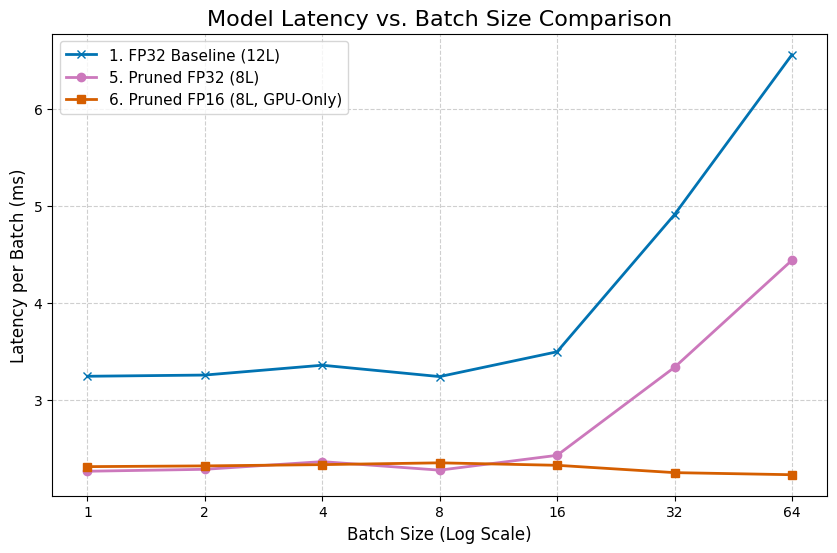

In [8]:
# --- 准备可视化数据 ---
df_latency = pd.DataFrame(latency_results)
print("\n--- Latency Comparison Table ---")
print(df_latency.to_markdown(index=False))

# --- 修改点 4: 循环绘图，应用指定配色和图例 ---
plt.figure(figsize=(10, 6))

for model_config in models_for_latency_test:
    model_name = model_config['name']
    subset_df = df_latency[df_latency["Model"] == model_name]
    plt.plot(
        subset_df["Batch Size"], 
        subset_df["Latency (ms)"], 
        marker=model_config['marker'], 
        label=model_name, 
        color=model_config['color'], 
        linewidth=2
    )

# --- 更新图表元素 ---
plt.xlabel("Batch Size (Log Scale)", fontsize=12)
plt.ylabel("Latency per Batch (ms)", fontsize=12)
plt.title("Model Latency vs. Batch Size Comparison", fontsize=16)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xscale('log', base=2)
plt.xticks(BATCH_SIZES, BATCH_SIZES) # 确保X轴刻度清晰显示所有批量大小

# --- 保存图表 ---
output_dir = 'figure'
output_filename = 'model_latency_comparison.svg'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, output_filename), format='svg', bbox_inches='tight', transparent=True)
print(f"\n图表已保存为可编辑的SVG文件: {os.path.join(output_dir, output_filename)}")

# 显示图表
plt.show()